In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# other imports can go here
from datetime import datetime
import pytz
import tqdm

In [3]:
df = pd.read_csv('revs_scored_jan.tsv', sep='\t', header=0)

In [4]:
days = df.rev_timestamp.map(lambda ts: datetime.utcfromtimestamp(ts).day)
df['day'] = days

In [5]:
# first thing: isolate data to only data from Jan1-Jan21, reverted w/in 24 hours, revisions by a bot

sdf = df[df.day<22]
sdf_reverted = sdf[sdf.is_reverted] # w/o, still include 'none'
sdf_reverted_in_day = sdf_reverted[sdf_reverted.seconds_to_revert.astype('str').astype('int')<86400]
sdf_bots = sdf_reverted_in_day[sdf_reverted_in_day.user_is_bot]
# sdf_bots = revisions from week 1-3 which were reverted within 24 hours

In [6]:
# to do next: find which in df_bots match rev_id of where user_is_bot is true?
sdf_another = df[df.user_is_bot]
sdf_another = sdf_another[sdf_another.is_revert]
#sdf_another = all of the bots that reverted a edit/revision

In [7]:
# sdf_bots holds reverted stuff within 3 weeks by bots
sdf1 = sdf_bots.loc[sdf_bots.is_reverted, ["rev_id", "user_text", "revert_id"]]
sdf1.revert_id = sdf1.revert_id.astype('int')

# sdf_another holds possible reverting changes
sdf2 = sdf_another[["rev_id", 'user_text']]

In [8]:
# subset bot-bot reverts using merge

bot_bot_reverts = pd.merge(sdf1, sdf2, 
             how='inner', 
             left_on='revert_id', 
             right_on='rev_id', 
             suffixes=('', '_reverter')
)

In [9]:
bot_pairs = bot_bot_reverts.groupby(["user_text","user_text_reverter"], as_index = False).count().sort_values("rev_id", ascending=False).reset_index()

In [10]:
bot_pairs

bot_pairs["is_self_revert"] = False

for row in bot_pairs.itertuples():
    if row.user_text_reverter == row.user_text:
        bot_pairs.loc[row.Index, "is_self_revert"] = True

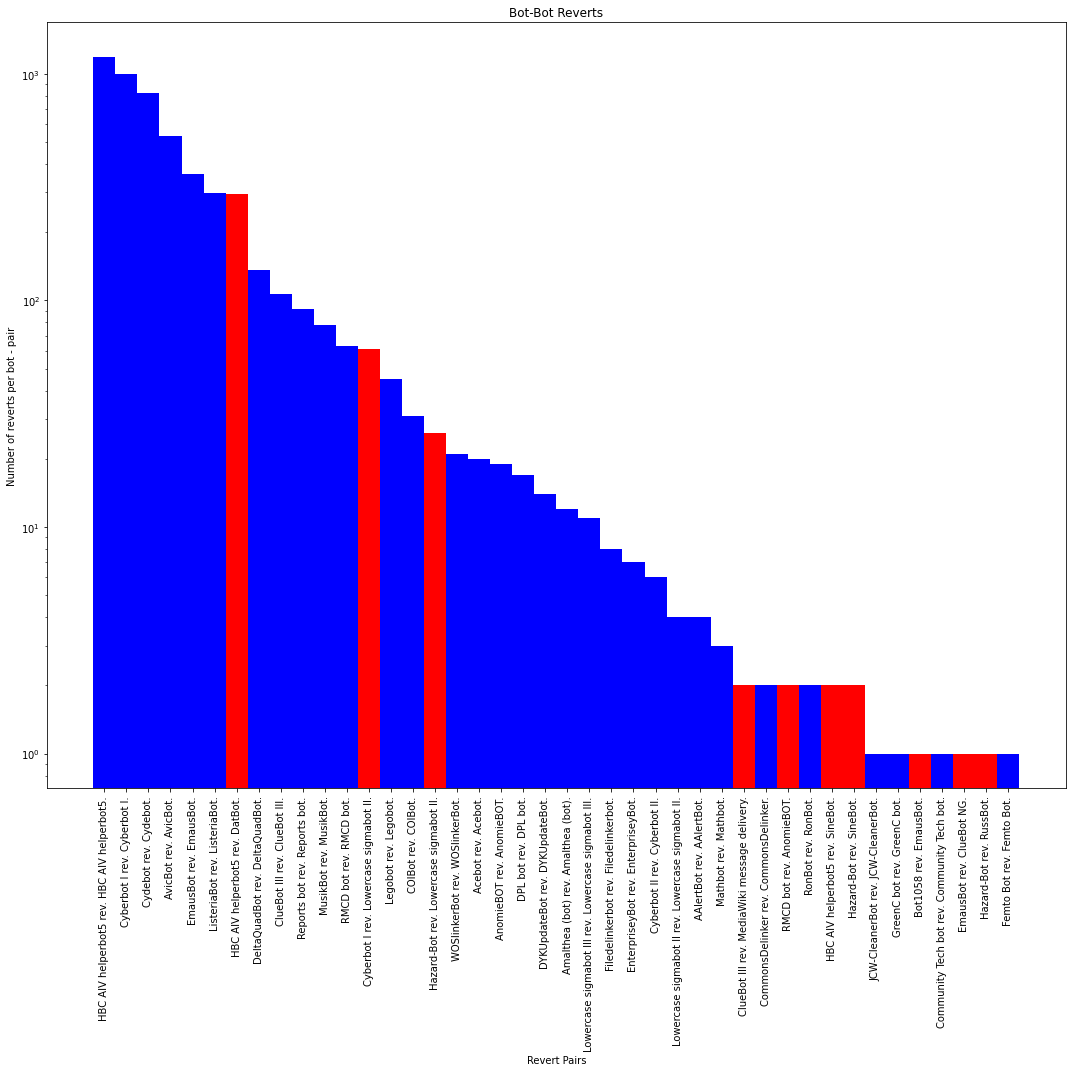

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(15, 15))

y = range(len(bot_pairs))

col = []
for val in bot_pairs.is_self_revert:
    if val:
        col.append('blue')
    else:
        col.append('red')

axes.bar(y, bot_pairs.rev_id, width=1, color = col)

axes.set_ylabel("Number of reverts per bot - pair")
axes.set_xlabel("Revert Pairs")
axes.set_title("Bot-Bot Reverts")

axes.set_yscale('log')

axes.set_xticks(y)
axes.set_xticklabels([f"{row.user_text_reverter} rev. {row.user_text}." for row in bot_pairs.itertuples()], rotation='vertical')

plt.tight_layout()
plt.show()

Samples of bot-bot self reverts (top 5 self-reverters)
=====

HBC AIV helperbot5
==

* first pair of reverts: reverting id changes to no admin backlog, very similar but not identical to the rev_id. 

* 2nd pair: changes don't seem related at all. 

* 3rd pair: changes again don't seem related. switching backlog and no backlog templates

* 4th pair: pretty similar

* 5th pair: different page - usernames for admin attention. edits are clearly related, helperbot just removes one after an admin blocked them

note: only IP addresses on HBC AIV page seem to have deleted contribs and IP info links

In [12]:
bot_bot_reverts[bot_bot_reverts.user_text == "HBC AIV helperbot5"].sample(n=5, random_state=1)

,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter
2575,877519272,HBC AIV helperbot5,877519379,877519379,HBC AIV helperbot5
4702,879112708,HBC AIV helperbot5,879112964,879112964,HBC AIV helperbot5
5233,879488235,HBC AIV helperbot5,879489481,879489481,HBC AIV helperbot5
3614,878418911,HBC AIV helperbot5,878419006,878419006,HBC AIV helperbot5
3363,878145874,HBC AIV helperbot5,878153478,878153478,HBC AIV helperbot5


Cyberbot I
==

* first revert: Cyberbot removes stuff from template, adds it again later. has to do with RfA somehow: https://en.wikipedia.org/wiki/Wikipedia_administrators#Requests_for_adminship none of the changes create a visible change to the page

* 2nd pair: pretty much the same, still editing Cyberpower678 page about RfA tallys?

* 3rd pair: same page, same edits. gets rid of stuff in one edit, next time re adds the exact same stuff in the same minute

* 4th pair: exact same as last. numbers in template are different for every pair

* 5th pair: adds lines to template, removes them in revert. within same minute



In [13]:
bot_bot_reverts[bot_bot_reverts.user_text == "Cyberbot I"].sample(n=5, random_state=1)

,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter
3773,878532936,Cyberbot I,878554876,878554876,Cyberbot I
1139,876597935,Cyberbot I,876599715,876599715,Cyberbot I
1095,876585270,Cyberbot I,876585275,876585275,Cyberbot I
712,876428515,Cyberbot I,876428519,876428519,Cyberbot I
1327,876614945,Cyberbot I,876615344,876615344,Cyberbot I


Cydebot
===

* on list of wikipedians looking for help, adds something to page and empties it again 2.5 hours later

* on list of wikipedians wanting to be unblocked, adds something to page and empties it again 30 mins later. seems to be maintaining list

* on files for deletion page, removing files and changing order. later empties page. not really related edits

* on list of requests for help, adds user and removes again 30 mins later. exact revert

* on list of candidates for speedy deletion page, adds page and removes again 30 mins later. exact revert. possibly keeping track of pages with speedy deletion template on them?

note: would be nice if bots left more explanation in summary. not very helpful...

In [14]:
bot_bot_reverts[bot_bot_reverts.user_text == "Cydebot"].sample(n=5, random_state=1)

,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter
832,876465236,Cydebot,876484755,876484755,Cydebot
4441,878945291,Cydebot,878948266,878948266,Cydebot
8,876290878,Cydebot,876373440,876373440,Cydebot
2080,877140695,Cydebot,877143668,877143668,Cydebot
2170,877214245,Cydebot,877216003,877216003,Cydebot


AvicBot
===

* on AfCCSD page (what does that mean?), adds a user for empty page, later returns page to empty state

* on same page, adds draft one edit, removes 1 hour later

* on AvicBot/speedy page, adding and deleting various pages, categories, and drafts. unsure about the purpose of this list

* on AfCCSD page, empties page and empties again later

* adding and removing drafts from AfCCSD page.

note: looked at these pages and are no longer in use as of July 2020


In [15]:
bot_bot_reverts[bot_bot_reverts.user_text == "AvicBot"].sample(n=5, random_state=1)

,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter
1654,876773821,AvicBot,876776787,876776787,AvicBot
2713,877630206,AvicBot,877638714,877638714,AvicBot
4260,878854297,AvicBot,878855123,878855123,AvicBot
4304,878872180,AvicBot,878875224,878875224,AvicBot
2640,877568508,AvicBot,877574318,877574318,AvicBot


EmausBot
===

* fixes double redirect after page is moved by Wikipedian. is revert because removes spelling added in previous re-direct

* people fighting over airport page name, emausbot fixes redirect both times 

* again, people fighting over page name, emausbot fixes redirect 

* again, people fighting over page name, emausbot fixes redirect 

* again, people fighting over page name

In [16]:
bot_bot_reverts[bot_bot_reverts.user_text == "EmausBot"].sample(n=5, random_state=1)

,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter
4208,878850902,EmausBot,878983549,878983549,EmausBot
4117,878782488,EmausBot,878887093,878887093,EmausBot
1667,876782153,EmausBot,876871132,876871132,EmausBot
2257,877284132,EmausBot,877285250,877285250,EmausBot
2586,877528739,EmausBot,877529551,877529551,EmausBot


Samples of bot-bot non-self-reverts
===

Helperbot5 rev. DatBot
==

* already went over this, but these bots are collborating with each other, DatBot reports users, and If those users are blocked, helperbot5 removes from the list and explains why , as you can see with the first rev ID, Datbot reported a user and explained why, and Helperbot5 removed it because it was blocked indef by MaterailScientist...


In [17]:
bot_bot_reverts[bot_bot_reverts.user_text == "DatBot"].sample(n=5, random_state=1)

,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter
4942,879292081,DatBot,879292225,879292225,HBC AIV helperbot5
4546,879027498,DatBot,879027603,879027603,HBC AIV helperbot5
4143,878809241,DatBot,878809452,878809452,HBC AIV helperbot5
4881,879251078,DatBot,879252045,879252045,HBC AIV helperbot5
5294,879548013,DatBot,879548078,879548078,HBC AIV helperbot5


Cyberbot I rev. Lowercase sigmabot II
==

* 1st pair: ssigma bot 2 seems to have reinserted a sandbox (its a template) and Cyberobt 1 seems to have cleared the sandbox, the info box to be exact, don't know why, its job is to maintian bad image list...interesting

* 2nd pair: sigmabot 2 has reinseted a sandbox again and Cyberbot 1 cleared the sandbox, on a template page, so its supposed to be doing this i guess? (reverted a user's edits though) 

* 3rd pair: again, the two bots seems to be colloborating, sigmabot 2 inserts a heading and then cyberbot 1 removes it regularly, seems to be another user editing as well, no suprise

note: none of the reverts we looked at so far are in the mainspace...good thing?!

In [18]:
bot_bot_reverts[bot_bot_reverts.user_text == "Lowercase sigmabot II" ][bot_bot_reverts.user_text_reverter == "Cyberbot I"].sample(n = 5, random_state=1)
# better syntax from Zach: [(bot_bot_reverts.user_text == '')&(bot_bot_reverts.user_text_reverter == '')] 

<ipython-input-18-4a1846e6a44e>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bot_bot_reverts[bot_bot_reverts.user_text == "Lowercase sigmabot II" ][bot_bot_reverts.user_text_reverter == "Cyberbot I"].sample(n = 5, random_state=1)


,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter
3512,878326891,Lowercase sigmabot II,878368216,878368216,Cyberbot I
3613,878418462,Lowercase sigmabot II,878422380,878422380,Cyberbot I
215,876282709,Lowercase sigmabot II,876287632,876287632,Cyberbot I
4385,878918778,Lowercase sigmabot II,878920529,878920529,Cyberbot I
4433,878936362,Lowercase sigmabot II,878937010,878937010,Cyberbot I


Harzard-Bot rev. Lowercase sigmabot II
==

* 1st pair: looks pretty similar to what Cyberbot and sigmabot were doing, sigmabot 2 inserts a sandbox heading and then HazardBot cleans them (one of its functions) - collaborative work

* 2nd pair: same as before, sigmatbot 2 added a sandbox header and HazardBot cleaned it (with another user just editing, messing around I assume) 

* 3rd pair: still routine work, Hazard -Bot cleanign the page, seems liek two different users edited the same sandbox page?? are sandbox pages specific to one user or? The edits made by the users don't even seem related... (maybe an overall

In [19]:
bot_bot_reverts[bot_bot_reverts.user_text == "Lowercase sigmabot II" ][bot_bot_reverts.user_text_reverter == "Hazard-Bot"].sample(n = 5, random_state=1)

<ipython-input-19-f96077b290cc>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bot_bot_reverts[bot_bot_reverts.user_text == "Lowercase sigmabot II" ][bot_bot_reverts.user_text_reverter == "Hazard-Bot"].sample(n = 5, random_state=1)


,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter
4664,879094372,Lowercase sigmabot II,879121265,879121265,Hazard-Bot
3514,878331724,Lowercase sigmabot II,878341910,878341910,Hazard-Bot
4502,878989401,Lowercase sigmabot II,879014562,879014562,Hazard-Bot
2242,877276973,Lowercase sigmabot II,877299155,877299155,Hazard-Bot
4969,879307483,Lowercase sigmabot II,879339581,879339581,Hazard-Bot


ClueBot III rev. MediaWiki message delivery 
==

* 1st pair: seems as if the media Wiki delivers messages to pepople who ask for it, however, ClueBot archived this whole discussion thread because of this "|archivebox = yes", 

* 2nd pair: the same as before, mediawiki added a message, seemed like a newsletter, and cluebot archived the discussion, and no archivebox = yes, on this page...

note: maybe Cluebot doens't archive other ppls work within 24 hours....

In [20]:
bot_bot_reverts[bot_bot_reverts.user_text == "MediaWiki message delivery" ][bot_bot_reverts.user_text_reverter == "ClueBot III"]

<ipython-input-20-53f38a4ff516>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bot_bot_reverts[bot_bot_reverts.user_text == "MediaWiki message delivery" ][bot_bot_reverts.user_text_reverter == "ClueBot III"]


,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter
495,876357073,MediaWiki message delivery,876403364,876403364,ClueBot III
2096,877162532,MediaWiki message delivery,877180774,877180774,ClueBot III


RMCD Bot rev. AnomieBot 
== 

* 1st pair: RMCD bot just updates requested move dicussions and whats on that list i guess? and anomiebot substittuted that template, but RMCD reverted it...don't know why anomiebot substitued this and why rmcd reverted it... (within a minute)

* 2nd pair: same change as above, just on a different version on the page (alt)...weird


In [21]:
bot_bot_reverts[bot_bot_reverts.user_text == "AnomieBOT" ][bot_bot_reverts.user_text_reverter == "RMCD bot"]

<ipython-input-21-5508a4b90766>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bot_bot_reverts[bot_bot_reverts.user_text == "AnomieBOT" ][bot_bot_reverts.user_text_reverter == "RMCD bot"]


,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter
629,876404799,AnomieBOT,876404850,876404850,RMCD bot
630,876404826,AnomieBOT,876404854,876404854,RMCD bot


Analaysis of TOP 10 bots (ones that reverted the most and that were revereted the most) 
==


In [22]:
top10_reverted_bots = bot_bot_reverts.groupby(["user_text"], as_index = False).count().sort_values("rev_id", ascending=False).reset_index()

In [23]:
top10_reverted_bots.head(10)

,index,user_text,rev_id,revert_id,rev_id_reverter,user_text_reverter
0,22,HBC AIV helperbot5,1185,1185,1185,1185
1,10,Cyberbot I,1004,1004,1004,1004
2,12,Cydebot,820,820,820,820
3,4,AvicBot,532,532,532,532
4,17,EmausBot,361,361,361,361
5,25,ListeriaBot,298,298,298,298
6,15,DatBot,295,295,295,295
7,16,DeltaQuadBot,136,136,136,136
8,6,ClueBot III,107,107,107,107
9,32,Reports bot,92,92,92,92


In [24]:
top10_reverter_bots = bot_bot_reverts.groupby(["user_text_reverter"], as_index = False).count().sort_values("rev_id", ascending=False).reset_index()

In [25]:
top10_reverter_bots.head(10)

,index,user_text_reverter,rev_id,user_text,revert_id,rev_id_reverter
0,21,HBC AIV helperbot5,1482,1482,1482,1482
1,10,Cyberbot I,1065,1065,1065,1065
2,12,Cydebot,820,820,820,820
3,4,AvicBot,532,532,532,532
4,16,EmausBot,361,361,361,361
5,25,ListeriaBot,298,298,298,298
6,15,DeltaQuadBot,136,136,136,136
7,7,ClueBot III,109,109,109,109
8,31,Reports bot,92,92,92,92
9,29,MusikBot,78,78,78,78


THE MOST REVERTED 
==


ListeriaBot 
==

* 1st pair: listerbot generates and updates lists based on wikidata, so that's why its reverting its own editss!
* 2nd : seems like another revision where listeria bot is just periodically updating the lists based on Wikidata

In [26]:
bot_bot_reverts[bot_bot_reverts.user_text == "ListeriaBot"].sample(n=5, random_state=1)

,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter
3054,877884434,ListeriaBot,877969297,877969297,ListeriaBot
4291,878865294,ListeriaBot,878984621,878984621,ListeriaBot
1519,876658997,ListeriaBot,876814780,876814780,ListeriaBot
3428,878193220,ListeriaBot,878352492,878352492,ListeriaBot
4392,878919995,ListeriaBot,879018720,879018720,ListeriaBot


DeltaQuadBot 
==

* 1st pair: the UTRS System is broken (a way to request an unblock) so this bot is just cleaning things up and updating the UTRS caselist until a new system is built, maybe when that person gets unblocked, it reerts its own edits 

* 2nd pair: updating the UTRS caselist, removed someone, seems routine!


In [27]:
bot_bot_reverts[bot_bot_reverts.user_text == "DeltaQuadBot"].sample(n=5, random_state=1)

,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter
1920,877046775,DeltaQuadBot,877111944,877111944,DeltaQuadBot
1890,876978938,DeltaQuadBot,876981436,876981436,DeltaQuadBot
3337,878110199,DeltaQuadBot,878118762,878118762,DeltaQuadBot
388,876321768,DeltaQuadBot,876452100,876452100,DeltaQuadBot
2657,877570253,DeltaQuadBot,877579387,877579387,DeltaQuadBot


ClueBot III
==

* 1st pair: ClueBot archives pages and this page was archived based on request, looks like ClueBot changed the date and nothing else, don't know why, but looks like routine work!

* 2nd pair: same page as above, added another year (2015) to the page, "setting index"

In [28]:
bot_bot_reverts[bot_bot_reverts.user_text == "ClueBot III"].sample(n=5, random_state=1)

,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter
3620,878426469,ClueBot III,878532618,878532618,ClueBot III
2394,877394355,ClueBot III,877500365,877500365,ClueBot III
3925,878628798,ClueBot III,878707690,878707690,ClueBot III
3206,877973693,ClueBot III,878044366,878044366,ClueBot III
2415,877406461,ClueBot III,877407434,877407434,ClueBot III


Reports bot 
==

* 1st pair: seems like its updating the discussion feeds for the WikiProjects, routine
* 2nd pair: same thign, moving things around to update the new discussions

In [29]:
bot_bot_reverts[bot_bot_reverts.user_text == "Reports bot"].sample(n=5, random_state=1)

,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter
2095,877157607,Reports bot,877168394,877168394,Reports bot
3050,877882558,Reports bot,877885660,877885660,Reports bot
1909,876978493,Reports bot,876985868,876985868,Reports bot
2027,877083796,Reports bot,877091707,877091707,Reports bot
3056,877885660,Reports bot,877889824,877889824,Reports bot


THE BOT THAT REVERTS THE MOST (that we haven't looked at already) 
==

MusikBot 
==

* 1st pair: keeps tracks of the number of pages under the extended confirmed protection (ppl allowed to edit, who've been a user for more than 30 days, etc.) 
* 2nd pair: 

In [30]:
bot_bot_reverts[bot_bot_reverts.user_text == "MusikBot"].sample(n=5, random_state=1)

,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter
4774,879147323,MusikBot,879183772,879183772,MusikBot
5238,879490896,MusikBot,879583007,879583007,MusikBot
2936,877802599,MusikBot,877865178,877865178,MusikBot
2173,877221056,MusikBot,877225681,877225681,MusikBot
4490,878973944,MusikBot,879039426,879039426,MusikBot


In [31]:
bot_pairs

,index,user_text,user_text_reverter,rev_id,revert_id,rev_id_reverter,is_self_revert
0,24,HBC AIV helperbot5,HBC AIV helperbot5,1185,1185,1185,True
1,11,Cyberbot I,Cyberbot I,1004,1004,1004,True
2,13,Cydebot,Cydebot,820,820,820,True
3,5,AvicBot,AvicBot,532,532,532,True
4,19,EmausBot,EmausBot,360,360,360,True
5,27,ListeriaBot,ListeriaBot,298,298,298,True
6,16,DatBot,HBC AIV helperbot5,295,295,295,False
7,17,DeltaQuadBot,DeltaQuadBot,136,136,136,True
8,7,ClueBot III,ClueBot III,107,107,107,True
9,36,Reports bot,Reports bot,92,92,92,True


especially confusing self-reverts: Cyberbot I, Avicbot, Cluebot III

* Sokona will look at Avicbot
* Abby will look at Cyberbot I